# SECTION 1: DECLARE THE MODULES

In [ ]:
import os
import time
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [3]:
import wget
!pip install wget

link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data, out="datasets")

100% [..................................................................................] 500 / 500

In [4]:
DataSet

'datasets/training_attack_types (1).txt'

In [5]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names
# file, but it is supposed to be a binary feature according to the
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(
    nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [6]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v, k) for k in category for v in category[k])

In [7]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [8]:
# Processing Training Data

train_df = pd.read_csv(
    'datasets/Week_5_NSL-KDD-Dataset/KDDTrain+.txt', names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
    .map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis=1, inplace=True)

In [9]:
test_df = pd.read_csv(
    'datasets/Week_5_NSL-KDD-Dataset/KDDTest+.txt', names=header_names)

test_df['attack_category'] = test_df['attack_type'] \
    .map(lambda x: attack_mapping[x])

test_df.drop(['success_pred'], axis=1, inplace=True)

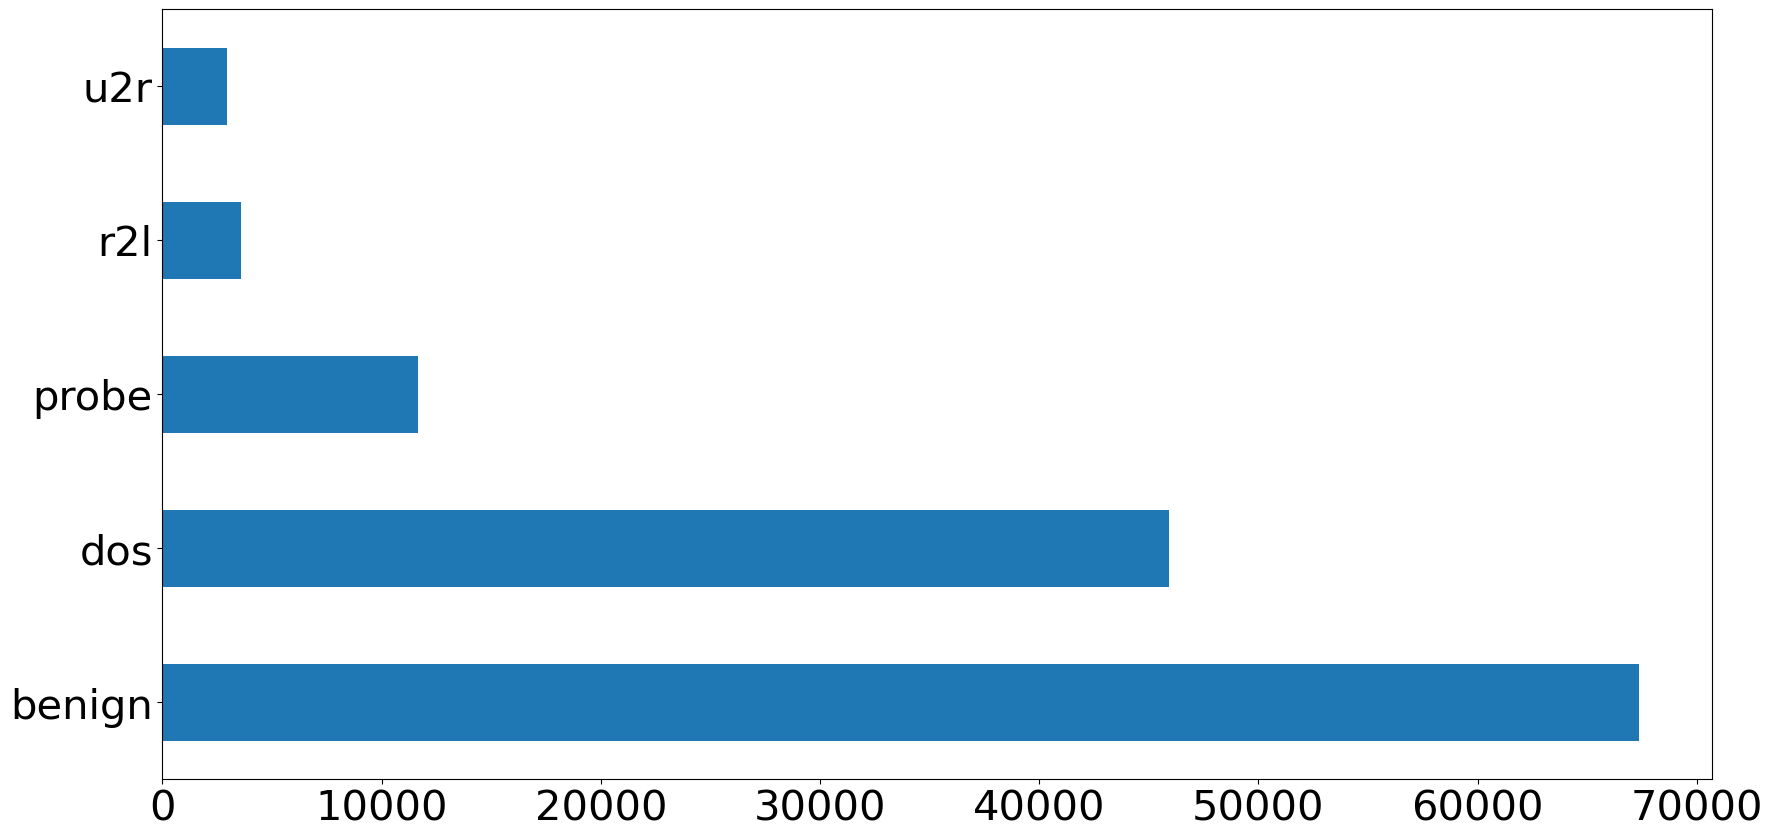

In [10]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20, 10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20, 10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis=1, inplace=True)
test_df.drop('num_outbound_cmds', axis=1, inplace=True)
numeric_cols.remove('num_outbound_cmds')


# Data Preparation

train_y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category', 'attack_type'], axis=1)
test_y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category', 'attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(
    combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

# execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

train_x.describe()


train_y_bin = train_y.apply(lambda x: 0 if x is 'benign' else 1)
test_y_bin = test_y.apply(lambda x: 0 if x is 'benign' else 1)

In [11]:
train_x['duration'].describe()

count    1.259730e+05
mean     2.549477e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
Name: duration, dtype: float64

# SECTION 3: Multi class classification on NSL-KDD

Since most of the classifier has the same model (thanks to scikit-learn implementation) and the same scoring methods, let us define a function that automate all of those tasks.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


def fit_and_score(cls, train_x, train_y, test_x, test_y):
    print("CLASSIFIER:")
    print(cls)
    print('==============================\n')

    start = time.time()
    cls.fit(train_x, train_y)
    end = time.time()
    print(f"FIT TIME: {end - start: .3f}s")
    print('==============================\n')

    start = time.time()
    pred_y = cls.predict(test_x)
    end = time.time()
    print(f"TEST TIME: {end - start: .3f}s")
    print('==============================\n')

    accu = accuracy_score(test_y, pred_y)
    print('ACCURACY: ', accu)
    print('==============================\n')

    label_order = test_y.unique()
    conf_matrix = confusion_matrix(test_y, pred_y, labels=label_order)
    index = pd.MultiIndex.from_product([['actual'], label_order])
    column = pd.MultiIndex.from_product([['predicted'], label_order])
    conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=column)
    print('CONFUSION MATRIX:\n', conf_matrix_df)
    print('==============================\n')

    results_str = classification_report(test_y, pred_y)
    results = classification_report(test_y, pred_y, output_dict=True)
    class_report = pd.DataFrame(results)
    print('CLASSIFICATION REPORT:\n')
    print(results_str)
    print('==============================\n')

    # if len(y_proba):
    #     roc_auc_scores = []
    #     for i in test_y.unique():
    #         mask = [x == i for x in test_y]
    #         test_y_one_rest = [1 if m else 0 for m in mask]
    #         pred_y_one_rest = np.max(y_proba, axis=1)
    #         roc_auc_scores.append(roc_auc_score(test_y_one_rest, pred_y_one_rest))
    #     print('ROC AUC:\n', roc_auc_scores)
    #     print('\n==============================\n')

    return conf_matrix, class_report

## KNearestNeighbor classifier



#### Hyperparameters tuning

In [47]:
grid = {
    "n_neighbors": np.arange(1, 30),
    "weights": ['uniform', 'distance'],
    "leaf_size": np.arange(1, 30)
}

cls = KNeighborsClassifier()
rgs = RandomizedSearchCV(cls, grid, cv=10, verbose=2, n_jobs=-1)

In [48]:
rgs.fit(train_x, train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [49]:
rgs.best_params_

{'weights': 'distance', 'n_neighbors': 2, 'leaf_size': 16}

#### Training model

In [57]:
knn = KNeighborsClassifier(n_neighbors=2, leaf_size=16, weights='distance')

lr_res = fit_and_score(knn, train_x, train_y, test_x, test_y)

CLASSIFIER:
KNeighborsClassifier(leaf_size=16, n_neighbors=2, weights='distance')

FIT TIME:  0.176s

TEST TIME:  11.128s

ACCURACY:  0.7578513129879347

CONFUSION MATRIX:
               predicted                      
                    dos benign probe  r2l u2r
actual dos         5892   1677    67    0   0
       benign        57   9457   193    2   2
       probe        156    670  1597    0   0
       r2l            2   2369    37  126  40
       u2r            0    176     4    7  13

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.77      0.86      7636
       probe       0.84      0.66      0.74      2423
         r2l       0.93      0.05      0.09      2574
         u2r       0.24      0.07      0.10       200

    accuracy                           0.76     22544
   macro avg       0.73      0.50      0.52     22544
weighted avg       0.81      0.76      0.72   

## Random forest

- Random Forest is a popular Machine Learning method that belongs to the Ensemble Learning methods, a class of algorithm that aims to combine outcome of multiple Machine Learning algorithms to give prediction. It achieves this by creating random decision tree and select the best classification outcome by ranking all results.
- Random Forest can be used for both classification and regression problem, and for this example, I use RandomForestClassifier from scikit-learn library.
- In theory, Random Forest should improve the result of single decision tree since 
    - it trains multiple decision trees on random features
    - by averaging all the outcomes, it should reduce the bias that we see on single decision tree
- Random forest can gives us a good overview on feature importance, which we will touch on later
- One drawback of random forest is due to its robust computations. For example, a random forest with 100 trees should significantly increase the training time on the same dataset, while making inferences will be longer.

### Hyperparameters tuning

In [28]:
forest_trees.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

- Let us fine the optimal values for these hyper-parameters:
    - n_estimator: the number of trees in the random forest
    - max_depth: the maximum height each tree can take
    - max_features: calculation of the max number of feature at each split
    - min_sample\_split: the minimum number of sample allowed at a leaf before splitting take place.
    - min_sample\_leaf: the minimum datapoint allowed in each node
    

In [39]:
# Define grid parameters
n_estimators = np.arange(1, 1000, 20)
max_depth = [None] + np.arange(1, 200, 10).tolist()
max_features = ['auto', 'sqrt']
min_samples_split = np.arange(2, 10)
min_samples_leaf = np.arange(2, 5)

grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "max_features": max_features,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf
}

# Initialize grid search
cls = RandomForestClassifier()
rgs = RandomizedSearchCV(cls, grid, n_iter=10, cv=10, verbose=2, n_jobs=-1)

In [ ]:
rgs.fit(train_x, train_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

In [45]:
rgs.best_params_

{'n_estimators': 181,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 111}

### Training model

Now that we have the optimal hyperparameters, let us train and evaluate on our testing set

In [22]:
forest_trees = RandomForestClassifier(n_estimators=181,
                                      min_samples_split=2,
                                      min_samples_leaf=3,
                                      max_features='sqrt',
                                      max_depth=111,
                                      random_state=17
                                      )

In [23]:
forest_result = fit_and_score(forest_trees, train_x, train_y, test_x, test_y)

CLASSIFIER:
RandomForestClassifier(max_depth=111, min_samples_leaf=3, n_estimators=181,
                       random_state=17)

FIT TIME:  15.127s

TEST TIME:  0.390s

ACCURACY:  0.7376242015613911

CONFUSION MATRIX:
               predicted                     
                    dos benign probe r2l u2r
actual dos         5651   1896    89   0   0
       benign        67   9460   184   0   0
       probe        164    822  1437   0   0
       r2l            0   2492     2  80   0
       u2r            0    196     3   0   1

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      benign       0.64      0.97      0.77      9711
         dos       0.96      0.74      0.84      7636
       probe       0.84      0.59      0.69      2423
         r2l       1.00      0.03      0.06      2574
         u2r       1.00      0.01      0.01       200

    accuracy                           0.74     22544
   macro avg       0.89      0.47      0.47     22544
weighte

## Logistic Regression with LogisticRegressionCV
- Logistic Regression is a popular classification method derived from the field of statistical learning. The main idea of this method revolve around the logistic function.
- The actual implementation for Logistic regression is a linear model
- scikit-learn library conveniently includes LogisticRegressionCV, or a built-in cross-validation model to find the most suitable hyper-parameter and generate the best result

In [51]:
lr = LogisticRegressionCV(cv=10, n_jobs=-1, max_iter=1000)

lr_res = fit_and_score(lr, train_x, train_y, test_x, test_y)

CLASSIFIER:
LogisticRegressionCV(cv=10, max_iter=1000, n_jobs=-1)



/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

[CV] END ........leaf_size=2, n_neighbors=7, weights=uniform; total time=  45.6s
[CV] END ......leaf_size=18, n_neighbors=19, weights=uniform; total time=  44.9s
[CV] END ......leaf_size=18, n_neighbors=19, weights=uniform; total time=  46.0s
[CV] END .....leaf_size=10, n_neighbors=18, weights=distance; total time=  45.4s
[CV] END .....leaf_size=15, n_neighbors=21, weights=distance; total time=  45.0s
[CV] END ......leaf_size=16, n_neighbors=2, weights=distance; total time=  45.8s
[CV] END .......leaf_size=26, n_neighbors=4, weights=uniform; total time=  44.5s
[CV] END .......leaf_size=26, n_neighbors=4, weights=uniform; total time=  47.1s
[CV] END ......leaf_size=29, n_neighbors=26, weights=uniform; total time=  45.9s
[CV] END .....leaf_size=28, n_neighbors=25, weights=distance; total time=  45.5s
[CV] END ......leaf_size=6, n_neighbors=19, weights=distance; total time=  47.9s
[CV] END ......leaf_size=15, n_neighbors=4, weights=distance; total time=  46.7s
[CV] END ........leaf_size=2

## Support Vector Machine

### Hyperparameters tuning

In [64]:
grid = {
    'kernel': ['rbf', 'linear'], 
    'C': [1, 10, 100, 1000]
}

cls = SVC()
rgs = RandomizedSearchCV(cls, grid, cv=3, verbose=2, n_jobs=-1)

In [65]:
rgs.fit(train_x, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .................................C=1, kernel=linear; total time= 3.3min
[CV] END ..................................C=100, kernel=rbf; total time= 1.3min
[CV] END .................................C=1000, kernel=rbf; total time= 1.2min
[CV] END .................................C=1000, kernel=rbf; total time= 1.3min
[CV] END ....................................C=1, kernel=rbf; total time= 3.1min
[CV] END ................................C=10, kernel=linear; total time= 4.2min
[CV] END ...................................C=10, kernel=rbf; total time= 2.0min
[CV] END ...................................C=10, kernel=rbf; total time= 1.8min
[CV] END ...............................C=100, kernel=linear; total time= 8.7min
[CV] END .................................C=1, kernel=linear; total time= 3.5min
[CV] END ...............................C=100, kernel=linear; total time= 8.4min
[CV] END ....................................C=1,

RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [1, 10, 100, 1000],
                                        'kernel': ['rbf', 'linear']},
                   verbose=2)

In [66]:
rgs.best_params_

{'kernel': 'rbf', 'C': 100}

### Training model

In [67]:
svc = SVC(kernel='rbf', C=100)

svc_res = fit_and_score(svc, train_x, train_y, test_x, test_y)

CLASSIFIER:
SVC(C=100)

FIT TIME:  26.841s

TEST TIME:  8.177s

ACCURACY:  0.7678317955997161

CONFUSION MATRIX:
               predicted                      
                    dos benign probe  r2l u2r
actual dos         6104   1436    96    0   0
       benign        65   9407   237    1   1
       probe        173    699  1551    0   0
       r2l            0   2320    11  239   4
       u2r            0    185     1    5   9

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      benign       0.67      0.97      0.79      9711
         dos       0.96      0.80      0.87      7636
       probe       0.82      0.64      0.72      2423
         r2l       0.98      0.09      0.17      2574
         u2r       0.64      0.04      0.08       200

    accuracy                           0.77     22544
   macro avg       0.81      0.51      0.53     22544
weighted avg       0.82      0.77      0.73     22544


[CV] END .................................C=1, ke

## Adaboost

### Hyper parameter tuning

### Training model

In [75]:
ada = AdaBoostClassifier(n_estimators=10000, random_state=0)

ada_res = fit_and_score(ada, train_x, train_y, test_x, test_y)

CLASSIFIER:
AdaBoostClassifier(n_estimators=10000, random_state=0)



KeyboardInterrupt: 

# SECTION 4: Multiclass classification on Dataset

In [2]:
dataset = pd.read_csv('datasets/Processed_Combined_IoT_dataset.zip')
dataset.head()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,current_temperature,door_state,fridge_temperature,humidity,latitude,light_status,longitude,motion_status,pressure,sphone_signal,temp_condition,temperature,thermostat_status,label
0,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.930769,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
1,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.588462,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0
2,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.076923,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
3,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.292308,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.8,0.517307,1,0
4,0.495216,0.499092,0.488897,0.499405,0.344399,0,0.746154,0.462511,0.008217,0,0.008112,0,0.533556,0.666667,0.2,0.517307,1,0


In [3]:
X = dataset.drop('label', axis=1) # Features
y = dataset['label'] # Target variable

In [4]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

Since this is a binary classification, we will add some more metrics

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_absolute_error


def fit_and_score_binary(cls, train_x, train_y, test_x, test_y):
    print("CLASSIFIER:")
    print(cls)
    print('==============================\n')

    start = time.time()
    cls.fit(train_x, train_y)
    end = time.time()
    print(f"FIT TIME: {end - start: .3f}s")
    print('==============================\n')

    start = time.time()
    pred_y = cls.predict(test_x)
    end = time.time()
    print(f"TEST TIME: {end - start: .3f}s")
    print('==============================\n')

    accu = accuracy_score(test_y, pred_y)
    print('ACCURACY: ', accu)
    print('==============================\n')

    label_order = test_y.unique()
    conf_matrix = confusion_matrix(test_y, pred_y, labels=label_order)
    index = pd.MultiIndex.from_product([['actual'], label_order])
    column = pd.MultiIndex.from_product([['predicted'], label_order])
    conf_matrix_df = pd.DataFrame(conf_matrix, index=index, columns=column)
    print('CONFUSION MATRIX:\n', conf_matrix_df)
    print('==============================\n')

    results_str = classification_report(test_y, pred_y)
    results = classification_report(test_y, pred_y, output_dict=True)
    class_report = pd.DataFrame(results)
    print('CLASSIFICATION REPORT:\n')
    print(results_str)
    print('==============================\n')

    # Scores
    print("Precision score:    ", precision_score(test_y, pred_y))
    print("Recall score:       ", recall_score(test_y, pred_y))
    print("Accuracy score:     ", accuracy_score(test_y, pred_y))
    print("F1 score:           ", f1_score(test_y, pred_y))
    print("Mean absolute error:", mean_absolute_error(test_y, pred_y))
    print("ROC AUC:            ", roc_auc_score(test_y, pred_y))
    
    return conf_matrix, class_report

## KNearestNeighbor classifier



#### Hyperparameters tuning

In [91]:
grid = {
    "n_neighbors": np.arange(1, 30),
    "weights": ['uniform', 'distance'],
    "leaf_size": np.arange(1, 30)
}

cls = KNeighborsClassifier()
rgs = RandomizedSearchCV(cls, grid, cv=5, verbose=2, n_jobs=-1)

In [92]:
rgs.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......leaf_size=28, n_neighbors=10, weights=uniform; total time= 1.7min
[CV] END .......leaf_size=1, n_neighbors=24, weights=uniform; total time= 1.7min
[CV] END ......leaf_size=5, n_neighbors=23, weights=distance; total time= 1.8min
[CV] END .......leaf_size=21, n_neighbors=1, weights=uniform; total time= 1.8min
[CV] END ......leaf_size=13, n_neighbors=8, weights=distance; total time= 1.7min
[CV] END .....leaf_size=5, n_neighbors=10, weights=distance; total time=109.1min
[CV] END ......leaf_size=28, n_neighbors=10, weights=uniform; total time= 1.7min
[CV] END .......leaf_size=1, n_neighbors=24, weights=uniform; total time= 1.7min
[CV] END ......leaf_size=5, n_neighbors=23, weights=distance; total time= 1.8min
[CV] END ......leaf_size=5, n_neighbors=23, weights=distance; total time= 1.8min
[CV] END .......leaf_size=21, n_neighbors=1, weights=uniform; total time= 1.7min
[CV] END .....leaf_size=5, n_neighbors=10, weigh

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

#### Training model

In [101]:
knn = KNeighborsClassifier(leaf_size=5, n_neighbors=10, weights="distance")

lr_res = fit_and_score_binary(knn, train_x, train_y, test_x, test_y)

CLASSIFIER:
KNeighborsClassifier(leaf_size=5, n_neighbors=10, weights='distance')

FIT TIME:  0.046s

TEST TIME:  35.108s

ACCURACY:  0.8669059965430129

CONFUSION MATRIX:
          predicted       
                 1      0
actual 1     34029  12812
       0      3204  70291

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     73495
           1       0.91      0.73      0.81     46841

    accuracy                           0.87    120336
   macro avg       0.88      0.84      0.85    120336
weighted avg       0.87      0.87      0.86    120336


Precision score:     0.913947304810249
Recall score:        0.7264789393907047
Accuracy score:      0.8669059965430129
F1 score:            0.8095011537455099
Mean absolute error: 0.1330940034569871
ROC AUC:             0.8414420685115983


## Random forest

### Hyperparameters tuning

In [102]:
# Define grid parameters
n_estimators = np.arange(1, 1000, 20)
max_depth = [None] + np.arange(1, 200, 10).tolist()
max_features = ['auto', 'sqrt']
min_samples_split = np.arange(2, 10)
min_samples_leaf = np.arange(2, 5)

grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "max_features": max_features,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf
}

# Initialize grid search
cls = RandomForestClassifier()
rgs = RandomizedSearchCV(cls, grid, n_iter=10, cv=5, verbose=2, n_jobs=-1)

In [103]:
rgs.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=461; total time=  30.8s
[CV] END max_depth=181, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=461; total time= 5.4min
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=461; total time=  30.7s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=461; total time=  31.8s
[CV] END max_depth=181, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=461; total time= 5.4min
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=461; total time=  30.7s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=461; total time=  31.7s
[CV] END max_depth=181, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=461; total time= 5.4min


/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/kdo/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=181, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=461; total time= 5.3min
[CV] END max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=181; total time= 2.0min
[CV] END max_depth=141, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=121; total time= 1.4min
[CV] END max_depth=141, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=121; total time= 1.4min
[CV] END max_depth=91, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=801; total time= 9.1min
[CV] END max_depth=91, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=621; total time= 6.0min
[CV] END max_depth=141, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=681; total time= 8.2min
[CV] END max_depth=151, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=921; total time=10.1min
[CV] END max_depth=91, max_features

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 1, 11, 21, 31, 41,
                                                      51, 61, 71, 81, 91, 101,
                                                      111, 121, 131, 141, 151,
                                                      161, 171, 181, 191],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': array([2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
       261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501,
       521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761,
       781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981])},
                   verbose=2)

In [104]:
rgs.best_params_

{'n_estimators': 681,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 141}

### Training model

Now that we have the optimal hyperparameters, let us train and evaluate on our testing set

In [105]:
forest_trees = RandomForestClassifier(**rgs.best_params_)

In [106]:
forest_result = fit_and_score_binary(forest_trees, train_x, train_y, test_x, test_y)

CLASSIFIER:
RandomForestClassifier(max_depth=141, max_features='auto', min_samples_leaf=2,
                       n_estimators=681)

FIT TIME:  298.422s

TEST TIME:  18.063s

ACCURACY:  0.8705873554048664

CONFUSION MATRIX:
          predicted       
                 1      0
actual 1     34249  12592
       0      2981  70514

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     73495
           1       0.92      0.73      0.81     46841

    accuracy                           0.87    120336
   macro avg       0.88      0.85      0.86    120336
weighted avg       0.88      0.87      0.87    120336


Precision score:     0.9199301638463605
Recall score:        0.7311756794261438
Accuracy score:      0.8705873554048664
F1 score:            0.8147637116246982
Mean absolute error: 0.12941264459513363
ROC AUC:             0.8453075485368013


## Logistic Regression with LogisticRegressionCV
- Logistic Regression is a popular classification method derived from the field of statistical learning. The main idea of this method revolve around the logistic function.
- The actual implementation for Logistic regression is a linear model
- scikit-learn library conveniently includes LogisticRegressionCV, or a built-in cross-validation model to find the most suitable hyper-parameter and generate the best result

In [107]:
lr = LogisticRegressionCV(cv=5, n_jobs=-1, max_iter=1000)

lr_res = fit_and_score_binary(lr, train_x, train_y, test_x, test_y)

CLASSIFIER:
LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1)

FIT TIME:  15.350s

TEST TIME:  0.017s

ACCURACY:  0.6882146656029783

CONFUSION MATRIX:
          predicted       
                 1      0
actual 1     10929  35912
       0      1607  71888

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.67      0.98      0.79     73495
           1       0.87      0.23      0.37     46841

    accuracy                           0.69    120336
   macro avg       0.77      0.61      0.58    120336
weighted avg       0.75      0.69      0.63    120336


Precision score:     0.8718091895341417
Recall score:        0.2333212356696057
Accuracy score:      0.6882146656029783
F1 score:            0.3681223369318087
Mean absolute error: 0.31178533439702166
ROC AUC:             0.6057279013234755


## Support Vector Machine
Due to limited resources, resampling is needed

In [6]:
from sklearn.utils import resample

train = pd.concat([train_x, train_y], axis=1)
train_rs = resample(train, n_samples=int(len(train) * 0.2), stratify=train_y)
train_rs_x, train_rs_y = train_rs.drop(columns=["label"]), train_rs['label']

test = pd.concat([test_x, test_y], axis=1)
test_rs = resample(test, n_samples=int(len(test) * 0.2), stratify=test_y)
test_rs_x, test_rs_y = test_rs.drop(columns=["label"]), test_rs['label']

### Hyperparameters tuning

In [17]:
grid = {
    'kernel': ['rbf', 'linear'], 
    'C': [1, 10, 100, 1000]
}

cls = SVC()
rgs = RandomizedSearchCV(cls, grid, cv=3, verbose=2, n_jobs=-1)

In [ ]:
rgs.fit(train_rs_x, train_rs_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
# [CV] END ....................................C=1, kernel=rbf; total time= 3.3min
# [CV] END ..................................C=100, kernel=rbf; total time=16.8min
# [CV] END .................................C=1000, kernel=rbf; total time=24.5min
# [CV] END ....................................C=1, kernel=rbf; total time= 3.2min
# [CV] END ................................C=10, kernel=linear; total time=20.2min
# [CV] END .................................C=1000, kernel=rbf; total time=24.2min
# [CV] END ....................................C=1, kernel=rbf; total time= 3.4min
# [CV] END ..................................C=100, kernel=rbf; total time=16.7min
# [CV] END ...............................C=100, kernel=linear; total time=28.0min
# [CV] END .................................C=1, kernel=linear; total time= 2.1min
# [CV] END ................................C=10, kernel=linear; total time=24.8min
# [CV] END ..............................C=1000, kernel=linear; total time=29.3min
# [CV] END .................................C=1, kernel=linear; total time= 2.1min
# [CV] END ................................C=10, kernel=linear; total time=23.2min
# [CV] END .................................C=1000, kernel=rbf; total time=31.3min
# [CV] END ...................................C=10, kernel=rbf; total time= 4.7min
# [CV] END ..................................C=100, kernel=rbf; total time=25.3min
# [CV] END ..............................C=1000, kernel=linear; total time=26.7min
# [CV] END ...................................C=10, kernel=rbf; total time= 4.9min
# [CV] END ...............................C=100, kernel=linear; total time=29.8min
# [CV] END ..............................C=1000, kernel=linear; total time=22.5min

In [ ]:
rgs.best_params_v

### Training model

In [8]:
svc = SVC(kernel="linear", C=1000)

svc_res = fit_and_score_binary(svc, train_rs_x, train_rs_y, test_rs_x, test_rs_y)

CLASSIFIER:
SVC(C=1000, kernel='linear')

FIT TIME:  1193.848s

TEST TIME:  15.065s

ACCURACY:  0.700087256409191

CONFUSION MATRIX:
          predicted       
                 1      0
actual 1      2518   6850
       0       368  14331

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.68      0.97      0.80     14699
           1       0.87      0.27      0.41      9368

    accuracy                           0.70     24067
   macro avg       0.77      0.62      0.60     24067
weighted avg       0.75      0.70      0.65     24067


Precision score:     0.8724878724878725
Recall score:        0.2687873612297182
Accuracy score:      0.700087256409191
F1 score:            0.4109678472335564
Mean absolute error: 0.299912743590809
ROC AUC:             0.6218758222571478
